In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
display(HTML("<style>.container { width:100% !important; }</style>"))

# FASE 2: Visualización

**0. INTRODUCCIÓN**

Para la visualización de los datos se han usado varias librerias que proporcionan una óptima imagen gráfica de los resultados.

**1. IMPORTACIÓN DE LIBRERIAS**

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from datetime import datetime, time
from folium import plugins
from IPython.display import IFrame

**2.CARGA DE LOS DATOS**

A continuación se declara el siguiente dataframe generado en pandas y cargado a través de un archivo en csv llamado **dataset_covid2019** en la ruta relativa "../../data/dataset_covid2019.csv", donde están contenidas las variables categóricas y  numéricas.

In [4]:
df = pd.read_csv("../../data/dataset_covid2019.csv", encoding = "utf-8")

**3. VISUALIZACIÓN E INTERPRETACIÓN DE LOS RESULTADOS**

Ante la riqueza de la información que disponemos se han determinado realizar distintas visualizaciones para conocer el comportamiendo del virus. Entre ellos, histogramas y matrices de correlación.

Para una mejor visualización de la dispersión del virus en el territorio se representan en formato de mapas los diagnosticados positivos en SARS CoV-2.

**3.1 Número de personas que dan positivo y negativo por estado**

En el siguiente gráfico se representan la cantidad de pacientes con diagnóstico positivo y negativo según el estado.

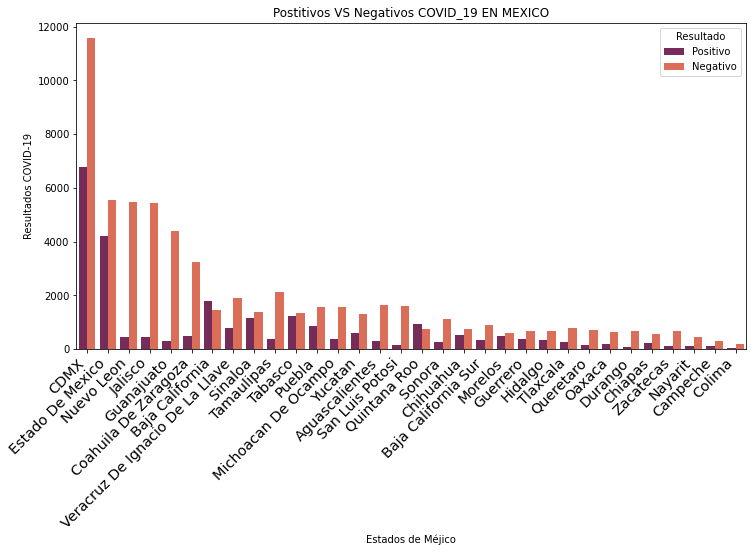

In [5]:
df_aux = df[(df["Resultado"]=='Positivo') | (df["Resultado"]=='Negativo')]
fig, ax = plt.subplots(figsize=(12,6))
p = sns.countplot(df_aux['Estado'],hue=df_aux["Resultado"],
             order = df['Estado'].value_counts().index, palette='rocket')
ax.set(xlabel='Estados de Méjico', ylabel='Resultados COVID-19')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')

leg = p.get_legend()
leg.set_title("Resultado")
labs = leg.texts
labs[0].set_text("Positivo")
labs[1].set_text("Negativo")

plt.title("Postitivos VS Negativos COVID_19 EN MEXICO")
plt.show()

Como se puede observar la concrentación de los positivos se situa en el estado de **Ciudad de Mejico**, con 6.785 positivos, corresponden al **27,24%** de los positivos del país. Con 11562 Negativos, es el estado con el mayor brote del país y dónde más test se estan realizando.

Por orden de importancia, le sigue el Estado de Mexico, con 4.202 positivos, el 16,87% del total de positivos del país.

Se puede apreciar que existe  mayor contagio en los países de la costa, como Baja California, Tabasco y Sinaloa.

Los estados con menor contagio son Colima con 30 contagios y Durango, con 80 contagios.

Se destaca la ciudad de Quintana Roo y Baja California como posible estado con fuerte brote, ya que la cantidad de contagiados supera a la de negativos, por lo que puede ser un indicio de actual brote.

**3.2 Evolución del fallecimiento**

A continuación se analiza el número de positivos del país a lo largo de los días en los que se ha tomado la muestra.

In [6]:
df_fallecidos = df[(df['Fecha_Def']!='9999-99-99')& (df["Resultado"]=='Positivo')].copy()
positivos = df[df["Resultado"]=='Positivo'].copy()

In [7]:
df_fallecidos['Fecha_Def'] = pd.to_datetime(df_fallecidos["Fecha_Def"], format = '%d/%m/%Y')
df_fallecidos = df_fallecidos.sort_values(by="Fecha_Def")

df_fallecidos['Fecha_Def'] = df_fallecidos['Fecha_Def'].apply(lambda x: x.strftime('%d-%m-%Y'))

positivos['Fecha_Sintomas'] = pd.to_datetime(positivos["Fecha_Sintomas"], format = '%d/%m/%Y')
positivos = positivos.sort_values(by="Fecha_Sintomas")

positivos['Fecha_Sintomas'] = positivos['Fecha_Sintomas'].apply(lambda x: x.strftime('%d-%m-%Y'))

In [8]:
fallecimientos = df_fallecidos.groupby('Fecha_Def', as_index = False)['Id_Registro'].count()
positiv = positivos.groupby('Fecha_Sintomas', as_index = False)['Id_Registro'].count()

fallecimientos = fallecimientos.rename(columns={"Fecha_Def": "Fecha"}, errors="raise")
positiv = positiv.rename(columns={"Fecha_Sintomas": "Fecha"}, errors="raise")

evolucion = pd.merge(left=fallecimientos, right=positiv, on = "Fecha")

evolucion = evolucion.rename(columns={"Id_Registro_x": "Fallecidos", 'Id_Registro_y': 'Contagios'}, errors="raise")

evolucion['Fecha'] = pd.to_datetime(evolucion['Fecha'], format = '%d-%m-%Y')
evolucion = evolucion.sort_values(by="Fecha")

In [9]:
evolucion = evolucion.reset_index(drop=True)

In [10]:
evolucion = evolucion.set_index('Fecha')

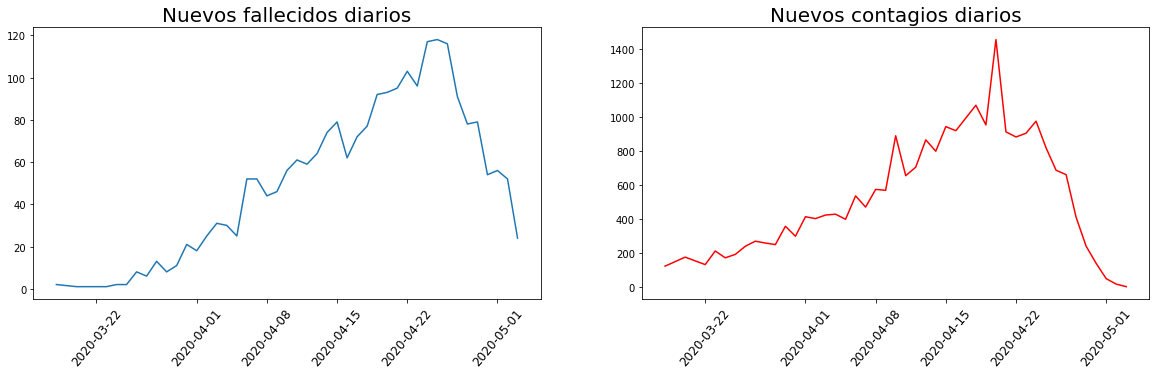

In [11]:
fig = plt.subplots(figsize=(20,5))
plt.subplot(1,2,1)  
plt.title("Nuevos fallecidos diarios", fontsize=20)
plt.xticks(rotation=50, fontsize=12)
plt.plot(evolucion["Fallecidos"])
plt.subplot(1,2,2)  
plt.title("Nuevos contagios diarios", fontsize=20)
plt.xticks(rotation=50, fontsize=12)
plt.plot(evolucion["Contagios"], color= "r")
plt.show()

Se aprecia un pico de nuevos contagios el 18 de marzo llegando a los más de 1.400 contagios diarios. Tras este pico de contagios podemos apreciar un aumento en los fallecimientos llegando a ser 120 fallecidos diarios durante varios dias consecutivos.

Como se puede observar en ambos gráficos tanto la curva de fallecidos como la curva de contagios esta en claro descenso. Esto puede ser debido a un retraso en la notificación de los datos.

**3.2 El municipio de cada estado con más positivos**

A continuanción se representa el municipio de cada estado que con más contagios.

In [12]:
positivos_municipio = positivos.groupby(["Estado","Municipio"]).\
        agg({"Municipio":["count"]})

positivos_municipio.columns = [str(i[0])+"_"+i[1] for i in positivos_municipio.columns.values]
positivos_municipio = positivos_municipio.reset_index()

estados = positivos_municipio["Estado"].unique()
maximos_municipios = pd.DataFrame(columns=["Estado","Municipio","Casos"])

for i in estados:
    municipio = positivos_municipio[positivos_municipio["Estado"] == i].sort_values("Municipio_count",
                                                                                      ascending=False)["Municipio"].iat[0]
    casos = positivos_municipio[positivos_municipio["Estado"] == i].sort_values("Municipio_count",
                                                                 ascending=False)["Municipio_count"].iat[0]
    maximos_municipios = maximos_municipios.append({"Estado":i,"Municipio":municipio, "Casos": casos},\
                ignore_index=True)

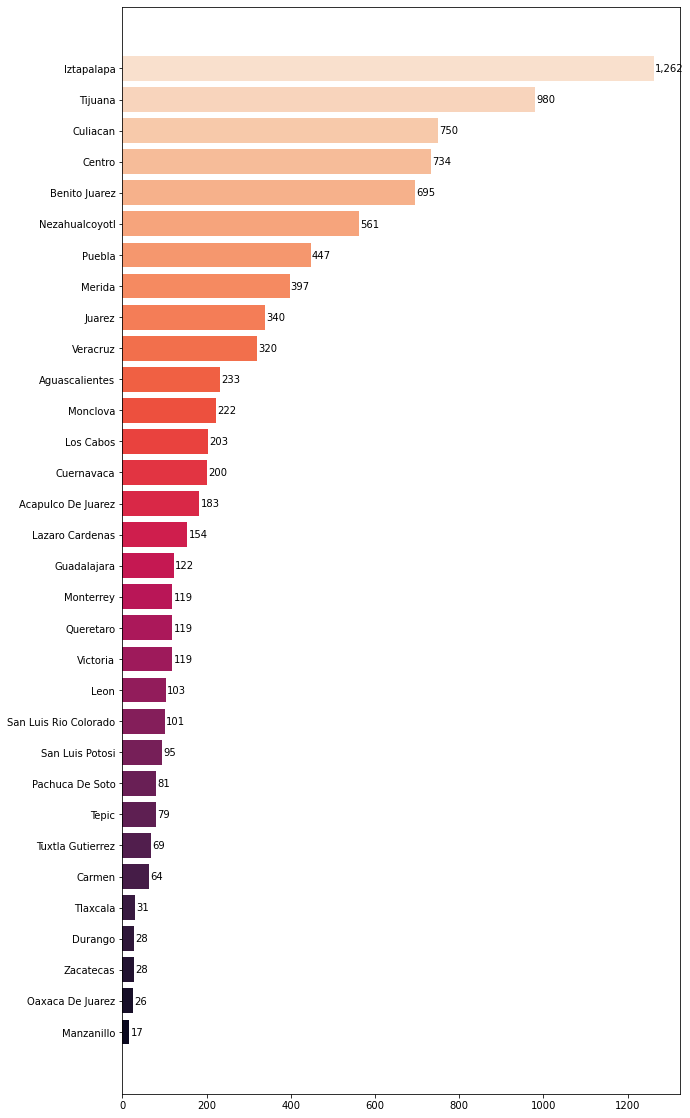

In [13]:
maximos_municipios = maximos_municipios.sort_values('Casos', ascending = True)

fig, grafico=plt.subplots(figsize=[10,20])
grafico.barh(maximos_municipios["Municipio"], maximos_municipios["Casos"],\
             color=sns.color_palette("rocket",len(maximos_municipios)))

for i,v in enumerate (maximos_municipios["Casos"]):
    grafico.text(v + 3, i -0.1 , f"{v:,d}")

plt.show()

Se puede comprobar como el miunicipio de Iztapalapa, del estado de CDMX, destaca entre todos los municipios con **1.262** contagios. Esta cifra representa el 18.59% de los contagiados del estado de Ciudad de Mexico. Le continua el municipo de Tijuana, con 980 positivos en SARS CoV-2 representando el 23,32% de los positivos del Estado de Mexico. Les siguen los municipios de Culiacan, Centro y Benito Juarez no superan los 750 contagios cada uno.

Los municipios menos afectados son Manzanillo y Ozxaca de Juarez con no más de 26 contagios.

**3.3 Distribución de máximos contagios por municipio de cada estado**

Para representar de una forma gráfica las cifras de contagios por municipios más pronunciados de cada estado, en el siguiente gráfico se muestra un diagrama de bigotes donde se han eliminado los valores atípicos.

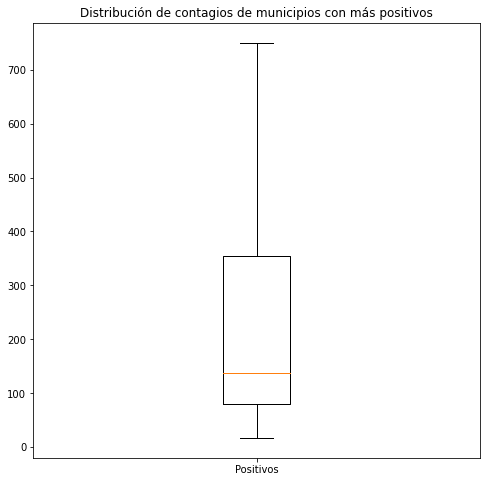

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
ax.boxplot(maximos_municipios["Casos"], labels=['Positivos'],showfliers=False)
ax.set_title('Distribución de contagios de municipios con más positivos')
plt.show()

Como se comprobar en el grafico anterior la **media de contagiados del pais es de 150 personas**, y la **distribución se concentra entre los 60 y 360 contagios**. La distribución tiene una pronunciada **asimetría positiva o segada a la derecha**, por lo que los datos se concentran en la parte inferior de la distribución. Se puede comprobar que el bigote superior es más largo que el inferior lo que quiere decir que **los datos superiores a la media estan más dispersos**.

**3.4 Distribución de las edades que han dado positivo entre hombres y mujeres**

En la siguiente figura se muestra la distribución entre sexos de los contagiados del pais.

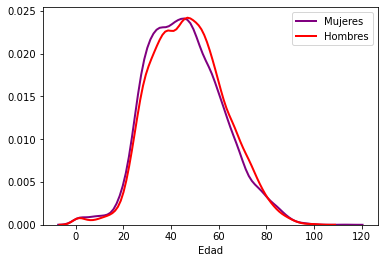

In [15]:
sns.distplot(positivos[positivos["Sexo"] == 'Mujer']['Edad'], kde_kws={"color": "purple", "lw": 2, "label": "Mujeres"}, hist=False)
sns.distplot(positivos[positivos["Sexo"] == 'Hombre']['Edad'], kde_kws={"color": "r", "lw": 2, "label": "Hombres"}, hist=False)
plt.show()

No se aprecian pronunciadas diferencias entre sexo y edad de los contagiados. En números, los hombres representan el 58% de los casos, y las mujeres el 42%, por lo que los hombres suponen una representación superior en 16 puntos que las mujeres en el total de contagios del pais. En cuanto a la edad las mujeres contagiadas tienen una media un punto menor que los hombres. Media de las mujeres 46 años y hombres 47.

Se concluye que existe una diferencia minima en cuanto al sexo, siendo los hombres de edades superiores a 47 años más propensos a contagios que las mujeres.

**3.5 Distribución de las edades que han dado negativo entre hombres y mujeres**

En este caso, se representa el sexo y la edad de los diagnosticados como negativos en SARS CoV-2.

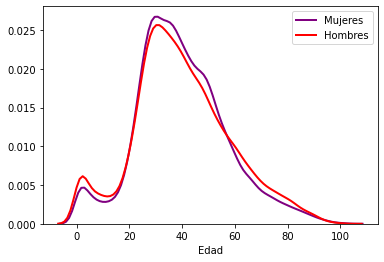

In [16]:
negativos = df[df["Resultado"]=='Negativo'].copy()

sns.distplot(negativos[negativos["Sexo"] == 'Mujer']['Edad'], kde_kws={"color": "purple", "lw": 2, "label": "Mujeres"}, hist=False)
sns.distplot(negativos[negativos["Sexo"] == 'Hombre']['Edad'], kde_kws={"color": "r", "lw": 2, "label": "Hombres"}, hist=False)
plt.show()

Se aprecia una diferencia entre sexo y edad de los no contagiados. En números, los hombres representan el 47% de los casos, y las mujeres el 52%. En cuanto a la edad las mujeres no contagiadas tienen una media menor en 8 puntos que los hombres. Media de las mujeres 39 años y hombres 47.

En este grafico se aprecia un pico en edades aproximadas a 0 que representan las pruebas realizadas a los bebes nacidos en estas fechas y con diagnósticos negativos.

Se concluye que las mujeres de edad aproximada a 39 años son menos propensas al contagio que los hombres.

**3.12 Dispersión de la edad de los fallecidos VS no fallecidos**

En el siguiente gráfico se representa la edad de los fallecidos y no fallecidos de los diágnosticos positivos de la población. Para realizar la representación no se toman en cuenta los outliers para representar unos datos más representativos.

In [17]:
def remove_outlier(df_in, col_name):
    """
    Esta funcion elimina los outliers de una columna. 
    Parameters
    ----------
    df_in : Data Frame -> Contiene las datos
    col_name: Contiene la columna a la que le queremos eliminar los outliers
    Return
    ------
    Devuelve el Data Frame sin outliers
    """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [18]:
df_no_fallecidos = df[(df['Fecha_Def']=='9999-99-99')& (df["Resultado"]=='Positivo')].copy()

In [19]:
f_without_outliers = remove_outlier(df_fallecidos, 'Edad')
f_without_outliers['Edad'].mean()

59.070765148164526

In [20]:
nf_without_outliers = remove_outlier(df_no_fallecidos, 'Edad')
nf_without_outliers['Edad'].mean()

45.318921328281704

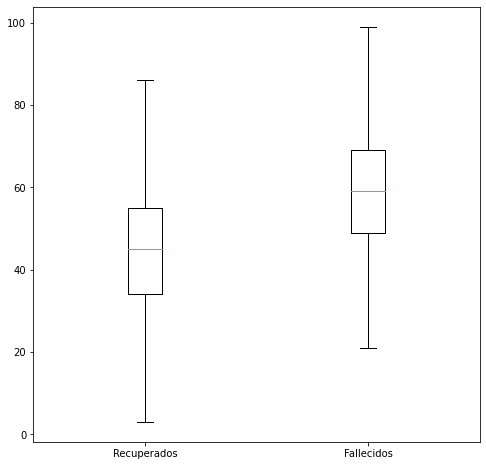

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
ax.boxplot([df_no_fallecidos["Edad"],df_fallecidos["Edad"]], labels=['Recuperados', 'Fallecidos'],showfliers=False)
plt.show()

Como se puede apreciar la edad media de las personas que fallecen es superior a las personas que superan el virus. Por lo que se puede concluir que el virus afecta más a las personas de edad más avanzada considerandose por ello grupos de riesgo las personas con una media de edad de 59 años. Por el contrario, la edad media de las personas no fallecidas esta en 45 años.

**3.6 Distribución de las personas que han fallecido entre hombres y mujeres**

Para concluir con el analisis de los fallecimientos se representa la cantidad de fallecimientos según la edad y el sexo.

In [22]:
df_fallecidos["Sexo"].value_counts(normalize=True)

Hombre    0.686344
Mujer     0.313656
Name: Sexo, dtype: float64

In [23]:
hombres_fallecidos = df_fallecidos[df_fallecidos["Sexo"] == 'Hombre']
m_without_outliers = remove_outlier(hombres_fallecidos, 'Edad')
m_without_outliers['Edad'].mean()

58.18891038039974

In [24]:
mujeres_fallecidas = df_fallecidos[df_fallecidos["Sexo"] == 'Mujer']
f_without_outliers = remove_outlier(mujeres_fallecidas, 'Edad')
f_without_outliers['Edad'].mean()

61.27517730496454

In [25]:
df_fallecidos['Edad'].mode()

0    69
dtype: int64

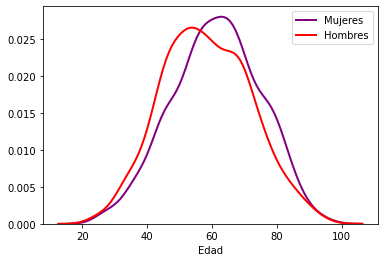

In [26]:
sns.distplot(f_without_outliers['Edad'], kde_kws={"color": "purple", "lw": 2, "label": "Mujeres"}, hist=False)
sns.distplot(m_without_outliers['Edad'], kde_kws={"color": "r", "lw": 2, "label": "Hombres"}, hist=False)
plt.show()

En este caso, se aprecia una diferencia considerable en cuanto a la edad de las mujeres y hombres fallecidos. En un primer lugar se aprecia que el **68% de los fallecidos son hombres** y el **31% mujeres**. La moda de la distribución de las edades es de 69 años, dato que indica que la edad que más se repite en los fallecidos es más alta que la media.

La **media de los hombres es de 58 años**. Y la media de las **mujeres fallecidas de 61 años**. Se confirma que la media de edad de hombres que fallecen es menor que la de las mujeres, por lo que más adelante se analiza la correlación de estas variables.

**3.7 Relación entre la necesidad de UCI e intubación según la edad y el sexo**

Para la siguiente representación se analizan las correlaciones entre la edad, el sexo y la necesidad de intubación y/o UCI de los positivos en SARS CoV-2.

In [27]:
df_corr = positivos[["Uci","Intubado","Sexo","Edad"]].copy()
df_corr_ = pd.get_dummies(df_corr)

df_corr_ = df_corr_.drop(columns=['Uci_No aplica', 'Uci_No especificado', 'Intubado_No aplica', 'Intubado_No especificado'])
df_corr_.head()

,Edad,Uci_No,Uci_Si,Intubado_No,Intubado_Si,Sexo_Hombre,Sexo_Mujer
93280,35,0,0,0,0,0,1
18339,47,0,0,0,0,0,1
97473,28,0,0,0,0,0,1
2361,22,1,0,1,0,1,0
19651,42,1,0,1,0,1,0


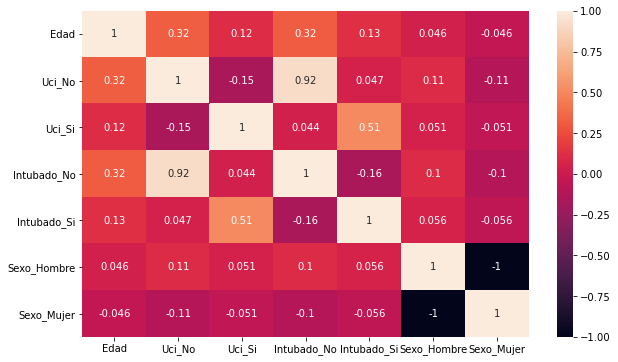

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_corr_.corr(), annot=True) 
plt.show()

En esta matriz de correlación se aprecia una correlación fuerte y positiva (0.92) entre pacientes que han **necesitado intubación** y los que no han **necesitado Uci**. Por lo que se puede concluir que la necesidad de soporte respiratorio es un sintoma de necesidad de cuidados intensivos.

Se aprecia una correlación no muy destacable de la edad con las necesidades de cuidados intensivos, lo que indica gravedad en la situación del paciente. Esta correlación es positiva de 0.32 por lo que no es concluyente.

En el siquiente caso, se analizan las variables con correlación en el resultado de fallecimiento, para lo cual se crea una columna de "Fallecidos" y se tendran en cuanta las variables de enfermedad previa.

In [29]:
positivos_enf = positivos[["Fecha_Def", 'Diabetes',
       'Epoc', 'Asma', 'Inmusupr', 'Hipertension', 'Otra_Com',
       'Cardiovascular', 'Obesidad', 'Renal_Cronica', 'Tabaquismo', "Edad"]].copy()
lst_falle = []
for i in positivos_enf['Fecha_Def']:
    if i == '9999-99-99':
        lst_falle.append(0)
    else:
        lst_falle.append(1)
positivos_enf['Fallecidos'] = lst_falle
positivos_enf = positivos_enf.drop(columns=['Fecha_Def'])

In [30]:
positivos_enf.head()

,Diabetes,Epoc,Asma,Inmusupr,Hipertension,Otra_Com,Cardiovascular,Obesidad,Renal_Cronica,Tabaquismo,Edad,Fallecidos
93280,No,No,Si,No,No,No,No,No,No,No,35,0
18339,No,No,No,No,No,No,No,Si,No,No,47,0
97473,No,No,No,No,No,No,No,No,No,No,28,0
2361,No,No,No,No,No,No,No,No,No,No,22,0
19651,No,No,No,No,No,No,No,No,No,No,42,0


In [31]:
lista_enfermedades = list(df.columns)
lista_enfermedades = lista_enfermedades[19:29]

In [32]:
def conEnfermedad(*x):
    """Esta funcion filtra los pacientes que si tienen ninguna enfremedad. 
    Parameters
    ----------
    x : lista
        Contiene las respuestas en forma de booleano, de si tiene una enfermedad o no
    Return
    ------
    True : Boolean
    False : Boolean
    """
    if 'Si' in x:
        return True
    return False

In [33]:
positivos2 = positivos_enf[positivos_enf[lista_enfermedades].apply(lambda x: conEnfermedad(*x), axis=1)].copy()

In [34]:
positivos2["Enfermedad"] = 1

In [35]:
def sinEnfermedad(*x):
    """Esta funcion filtra los pacientes que no tienen ninguna enfremedad. 
    Parameters
    ----------
    x : lista
        Contiene las respuestas en forma de booleano, de si tiene una enfermedad o no
    Return
    ------
    True : Boolean
    False : Boolean
    """
    if 'Si' in x:
        return False
    return True

In [36]:
positivos3 = positivos_enf[positivos_enf[lista_enfermedades].apply(lambda x: sinEnfermedad(*x), axis=1)].copy()

In [37]:
positivos3["Enfermedad"]=0

In [38]:
positivos2 = positivos2.append(positivos3)

In [39]:
positivos2

,Diabetes,Epoc,Asma,Inmusupr,Hipertension,Otra_Com,Cardiovascular,Obesidad,Renal_Cronica,Tabaquismo,Edad,Fallecidos,Enfermedad
93280,No,No,Si,No,No,No,No,No,No,No,35,0,1
18339,No,No,No,No,No,No,No,Si,No,No,47,0,1
81245,No,No,No,No,Si,No,Si,No,No,No,88,0,1
88913,No,No,No,No,No,Si,No,Si,No,No,37,0,1
47768,No,Si,No,No,Si,No,No,No,No,No,65,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38213,No,No,No,No,No,No,No,No,No,No,53,0,0
28292,No,No,No,No,No,No,No,No,No,No,37,0,0
52412,No,No,No,No,No,No,No,No,No,No,75,0,0
25486,No,No,No,No,No,No,No,No,No,No,50,0,0


In [40]:
positivos2['Enfermedad'].value_counts()

1    12919
0    11985
Name: Enfermedad, dtype: int64

In [41]:
for i in positivos2.columns[:-3]:
    dummy_ = pd.get_dummies(positivos2[i], prefix = i)
    positivos2 = pd.concat([positivos2, dummy_], axis=1)
    del positivos2[i]

In [42]:
positivos2

,Edad,Fallecidos,Enfermedad,Diabetes_No,Diabetes_Se ignora,Diabetes_Si,Epoc_No,Epoc_Se ignora,Epoc_Si,Asma_No,...,Cardiovascular_Si,Obesidad_No,Obesidad_Se ignora,Obesidad_Si,Renal_Cronica_No,Renal_Cronica_Se ignora,Renal_Cronica_Si,Tabaquismo_No,Tabaquismo_Se ignora,Tabaquismo_Si
93280,35,0,1,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
18339,47,0,1,1,0,0,1,0,0,1,...,0,0,0,1,1,0,0,1,0,0
81245,88,0,1,1,0,0,1,0,0,1,...,1,1,0,0,1,0,0,1,0,0
88913,37,0,1,1,0,0,1,0,0,1,...,0,0,0,1,1,0,0,1,0,0
47768,65,0,1,1,0,0,0,0,1,1,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38213,53,0,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
28292,37,0,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
52412,75,0,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
25486,50,0,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0


In [43]:
positivos2 = positivos2.drop(columns=['Diabetes_Se ignora','Epoc_Se ignora',
                                      'Diabetes_No',
                                      'Epoc_No',
                                      'Asma_No',
                                      'Inmusupr_No',
                                      'Hipertension_No',
                                      'Otra_Com_No',
                                      'Cardiovascular_No',
                                      'Obesidad_No',
                                      'Renal_Cronica_No',
                                      'Tabaquismo_No',                                     
                                      'Asma_Se ignora',
                                      'Inmusupr_Se ignora',
                                      'Hipertension_Se ignora',
                                      'Otra_Com_Se ignora',
                                      'Cardiovascular_Se ignora',
                                      'Obesidad_Se ignora',
                                      'Renal_Cronica_Se ignora',
                                      'Tabaquismo_Se ignora'
                                     ])

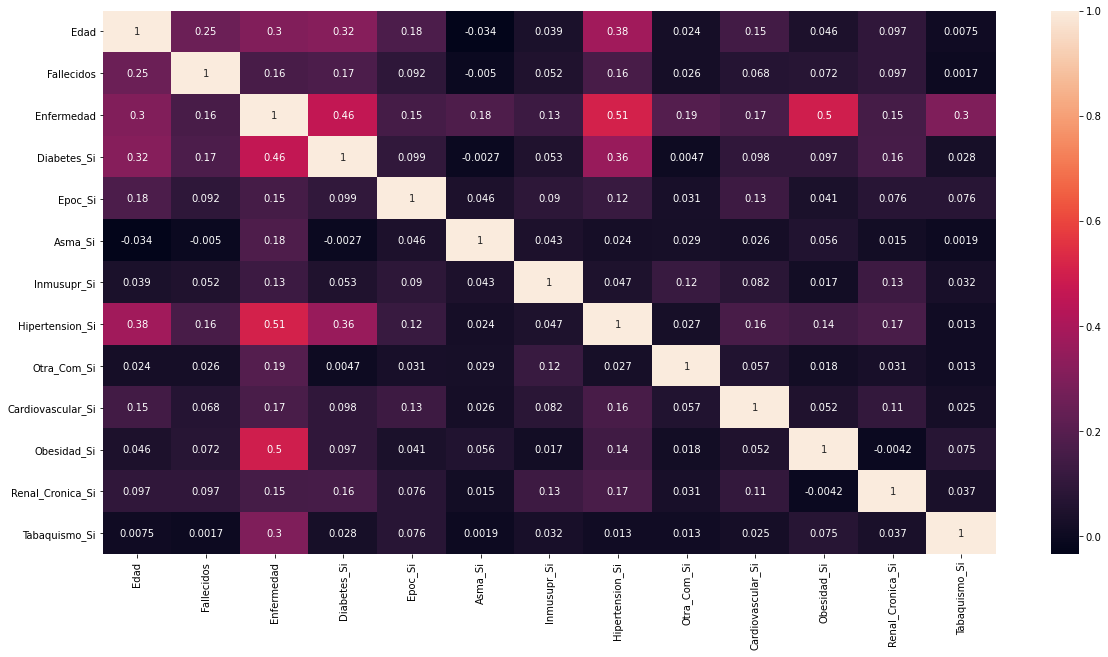

In [44]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(positivos2.corr(), annot=True) 
plt.show()

En conclusión podemos afirmar que el suceso de fallecimiento a causa del virus no se ve correlacionado con ninguna variable estudiada. Siendo la enfermedad previa una variable con correlación baja, del 0.16.

**3.8 Número de positivos para cada estado**

En primer lugar se representa la dispersión de los contagios según los estados Mejicanos sin tomar en cuenta valores atípicos.

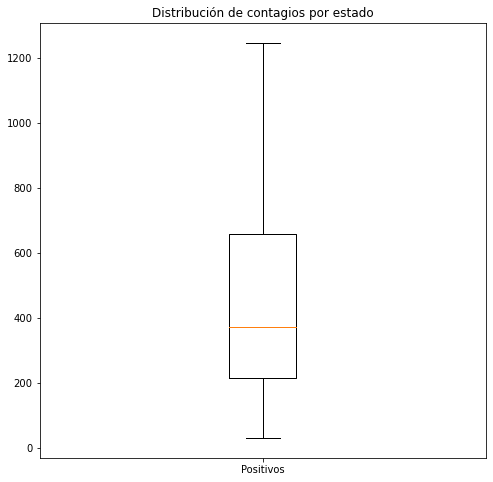

In [45]:
posi_estados = positivos.groupby(['Estado', 'Latitud', 'Longitud'], as_index=False)['Resultado'].count()

fig, ax = plt.subplots(figsize=(8,8))
ax.boxplot(posi_estados["Resultado"], labels=['Positivos'],showfliers=False)
ax.set_title('Distribución de contagios por estado')
plt.show()

La media de los contagiados por estado es de **380 positivos**, apreciandose una asimetria a la derecha y una dispersión de los datos más alta.

En la siguiente representación se muestra el número de positivos de cada estado en un mapa que permite interactuar mostrando el nombre del estado y la cantidad de contagiados al pulsar sobre él.

In [46]:
estados = list(posi_estados['Estado'])
resultados = list(posi_estados['Resultado'])

informacion = []
for i, j in zip(estados, resultados):
    informacion.append(i+': '+ str(j) +' positivos')
    
posi_estados['Info'] = informacion 

In [72]:
mapa_mejico = folium.Map(location=[23.634501, -102.552784], zoom_start=5)
individuos = folium.map.FeatureGroup()

for lat, lng, in zip(posi_estados.Latitud, posi_estados.Longitud):
    individuos.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, # difine el tamaño de los circulos
            color='red',
            fill=True,
            fill_color='yellow',
            fill_opacity=0.6
        )
    )

for lat, lng, label in zip(posi_estados.Latitud, posi_estados.Longitud, posi_estados.Info):
    folium.Marker([lat,lng], popup=label).add_to(mapa_mejico)
    
# Agrega incidentes al map
mapa_mejico.add_child(individuos)
mapa_mejico.save('map.html')
#Mostrar mapa desde formato html
IFrame(src='./map.html', width=1600, height=600)

En el siguiente mapa se representan los contagios a través de una escala de colores. En él podemos apreciar a simple vista dónde esta afectando más la pandemia en número de contagios.

In [75]:
mejico_geo = r'../../data/mexico.json'

mapa_mejico = folium.Map(location=[23.63, -102.55], zoom_start=5, tiles='Mapbox Bright')

folium.Choropleth(
    geo_data = mejico_geo,
    bins=9,
    data = posi_estados,
    columns = ['Estado', 'Resultado'],
    key_on = 'feature.properties.name',
    fill_color='Reds', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Positivos COVID Mejico'
).add_to(mapa_mejico)

folium.LayerControl().add_to(mapa_mejico)
mapa_mejico.save('map1.html')
#Mostrar mapa desde formato html
IFrame(src='./map1.html', width=1600, height=700)

Como se pueden observar, el estado más afectado esta siendo Ciudad de México. Con él, Estado de Mexico. Estos dos estados tienen cifras de contadiados muy diferentes al resto de los estados. En los que la media esta muy por debajo. Por lo que se concluye que son los estados de foco del brote en el país.
    
Se  puede apreciar como algunos estados de la costa cuentan con mayor número de contagios. Pudiendo ser por la densidad de la población y por ser zonas más turisticas. Se necesitarian más datos para obtener mejores conclusiones.